## Installing packages/libraries

In [3]:
!pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 2.4 MB/s eta 0:00:00


In [5]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.8 MB/s eta 0:00:00


In [8]:
!apt install unzip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


## Importing Libraries

In [1]:
import os
import faiss
from faiss import write_index, read_index
import torch
import re
import requests
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
from datasets import load_dataset
from collections import OrderedDict
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
import os
import torch
import requests
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import IPython.display
from datasets import load_dataset
from collections import OrderedDict
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
from io import StringIO
import glob
import time
import json
import zipfile
from tqdm.notebook import tqdm

## Mounting Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
#!unzip -u "/content/drive/My Drive/VectorSearchEngine/data/patent_figures.zip" -d "/content/drive/My Drive/VectorSearchEngine/data/patent_figures"

## Checking the number of images. It should be 67,515 segmented images.

In [3]:
# folder path
dir_path = '/content/drive/My Drive/VectorSearchEngine/data/patent_figures/segmented_50000_v4'
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
print('File count:', count)

File count: 67515


In [6]:
# # Opening JSON file and converting it to CSV file
# lst = []
# with open("/content/drive/My Drive/VectorSearchEngine/data/unique_100.json") as f:
#     json_data = json.load(f)
#     lst.append(json_data)
# data = pd.DataFrame(lst).T
# data.columns = ['object_names']
# data.to_csv("unique_obj.csv", index = False)

## Various Utilities (e.g., loading CLIP model, embedding functions, etc.)

In [7]:
# numbers = re.compile(r'(\d+)')
# def numericalSort(value):
#     parts = numbers.split(value)
#     parts[1::2] = map(int, parts[1::2])
#     return parts

########################## Reading all Images Path ##################################
file_path = "/content/drive/My Drive/VectorSearchEngine/data/patent_figures/segmented_50000_v4/*.png" ## Replace with your path if you need to create imageonly.csv file
def read_img_path(file):
        data = glob.glob(file, recursive=True)
        df = pd.DataFrame(data, columns = ['img_only'])
        return df

################################# CLIP MODEL ###################################

def get_model_info(model_ID, device):
    model = CLIPModel.from_pretrained(model_ID).to(device)
    processor = CLIPProcessor.from_pretrained(model_ID)
    tokenizer = CLIPTokenizer.from_pretrained(model_ID)
    return model, processor, tokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
model_ID = "openai/clip-vit-base-patch32"
model, processor, tokenizer = get_model_info(model_ID, device)

################################### IMAGE EMBEDDINGS ########################################

def get_single_text_embedding(text):
    inputs = tokenizer(text, return_tensors = "pt").to(device)
    text_embeddings = model.get_text_features(**inputs)
     # convert the embeddings to numpy array
    embedding_as_np = text_embeddings.cpu().detach().numpy()
    return embedding_as_np

################################### TEXT EMBEDDINGS ########################################

def get_single_image_embedding(my_image):
    image = processor(text = None, images = my_image, return_tensors="pt")["pixel_values"].to(device)
    embedding = model.get_image_features(image)
    # convert the embeddings to numpy array
    embedding_as_np = embedding.cpu().detach().numpy()
    return embedding_as_np

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

## Processing metadata files and added the segmented images (i.e., subfigure_file) path to the metadata file in a new Column

In [9]:
metadata = pd.read_csv('/content/drive/My Drive/VectorSearchEngine/data/nipseval_50000_original.csv') ## change this path based on where you saved the metadata file
figure_file = metadata['subfigure_file'] ## this is the column of segemented images
img_path = "/content/drive/My Drive/VectorSearchEngine/data/patent_figures/segmented_50000_v4/" ## change this path based on where you dowloaded the images

lst1 = []
for i in figure_file:
    f = img_path+i
    lst1.append(f)

dataframe = pd.DataFrame(lst1, columns = ['figure_path'])
dataframe.to_csv('imagepath.csv', index = None)

In [10]:
img_path = pd.read_csv('imagepath.csv')
result = pd.concat([metadata, img_path], axis = 1)
result = result.replace(np.nan, 'none', regex = True)
result.to_csv('patent_67000_segmented_metadata.csv', index = None)

In [11]:
result

,patentID,patentdate,figid,caption,object_infer,aspect,figure_file,subfigure_file,object_title,figure_path
0,USD0884696-20200519,2020-05-19,1,FIG. 1 is a perspective view of a display with...,display with connector and cover,perspective view,USD0884696-20200519-D00001.png,USD0884696-20200519-D00001_1.png,Display with connector and cover,/content/drive/My Drive/VectorSearchEngine/dat...
1,USD0884696-20200519,2020-05-19,2,FIG. 2 is a front view thereof;,display with connector and cover,front view,USD0884696-20200519-D00002.png,USD0884696-20200519-D00002_2.png,Display with connector and cover,/content/drive/My Drive/VectorSearchEngine/dat...
2,USD0884696-20200519,2020-05-19,3,FIG. 3 is a first side view thereof;,display with connector and cover,side view,USD0884696-20200519-D00003.png,USD0884696-20200519-D00003_3.png,Display with connector and cover,/content/drive/My Drive/VectorSearchEngine/dat...
3,USD0884696-20200519,2020-05-19,4,FIG. 4 is a second side view thereof;,display with connector and cover,side view,USD0884696-20200519-D00003.png,USD0884696-20200519-D00003_4.png,Display with connector and cover,/content/drive/My Drive/VectorSearchEngine/dat...
4,USD0884696-20200519,2020-05-19,5,FIG. 5 is a top view thereof;,display with connector and cover,top view,USD0884696-20200519-D00004.png,USD0884696-20200519-D00004_5.png,Display with connector and cover,/content/drive/My Drive/VectorSearchEngine/dat...
...,...,...,...,...,...,...,...,...,...,...
67510,USD0694423-20131126,2013-11-26,1,FIG. 1 is a perspective view of a disposable a...,disposable apparatus for cell separation,perspective view,USD0694423-20131126-D00001.png,USD0694423-20131126-D00001_1.png,Disposable apparatus for cell separation,/content/drive/My Drive/VectorSearchEngine/dat...
67511,USD0694423-20131126,2013-11-26,4,FIG. 4 is a bottom view thereof;,disposable apparatus for cell separation,bottom view,USD0694423-20131126-D00004.png,USD0694423-20131126-D00004_4.png,Disposable apparatus for cell separation,/content/drive/My Drive/VectorSearchEngine/dat...
67512,USD0694423-20131126,2013-11-26,5,FIG. 5 is a right side view thereof;,disposable apparatus for cell separation,right side view,USD0694423-20131126-D00005.png,USD0694423-20131126-D00005_5.png,Disposable apparatus for cell separation,/content/drive/My Drive/VectorSearchEngine/dat...
67513,USD0694423-20131126,2013-11-26,6,"FIG. 6 is a left side view thereof; and,",disposable apparatus for cell separation,left side view,USD0694423-20131126-D00006.png,USD0694423-20131126-D00006_6.png,Disposable apparatus for cell separation,/content/drive/My Drive/VectorSearchEngine/dat...


In [12]:
data = pd.read_csv('patent_67000_segmented_metadata.csv')
caps = data['object_infer']
viewpoint = data['aspect']
figure_path = data['figure_path']
title = data['object_title']

## Image Embeddings

In [14]:
# img_embed = []
# for img in tqdm(figure_path, desc = 'Image Embedding is Progress'):
#     images = Image.open(img, 'r')
#     image_embedding = get_single_image_embedding(images)
#     img_embed.append(image_embedding)

In [15]:
#torch.save(img_embed, 'image_embeddings_v1.pt')

## Text Embeddings

In [48]:
# text_embed = []
# for txt in tqdm(title, desc = 'Text Embedding is in Progress'):
#     text_embedding = get_single_text_embedding(txt)
#     text_embed.append(text_embedding)

Text Embedding is in Progress:   0%|          | 0/67515 [00:00<?, ?it/s]

In [49]:
# torch.save(text_embed, 'text_embeddings_v1.pt')

## Creating Vector Database for Image

In [92]:
###### Load the image embedding ######
embed = torch.load("./image_embeddings_v1.pt")
embed_arr = np.array(embed)
embed_slice = embed_arr[:,0,:] ## making the two dimensional array
print(np.shape(embed_slice))

(67515, 512)


In [93]:
img_embedding = embed_slice.shape[1]
img_embedding

512

In [94]:
#index = faiss.IndexFlatL2(img_embedding)
nlist = 5
quantizer = faiss.IndexFlatL2(img_embedding)
img_index = faiss.IndexIVFFlat(quantizer, img_embedding, nlist)

In [95]:
img_index.is_trained

False

In [96]:
img_index.train(embed_slice)
img_index.is_trained

True

In [97]:
img_index.add(embed_slice)
img_index.ntotal

67515

In [99]:
write_index(img_index, "image.index")

## Create a Vector Database for Text

In [56]:
###### Load the text embedding ######

txt_embed = torch.load("./text_embeddings_v1.pt") ## Replace with your path
txt_embed_arr = np.array(txt_embed)
txt_embed_slice = txt_embed_arr[:,0,:] ## making the two dimensional array
print(np.shape(txt_embed_slice))

(67515, 512)


In [57]:
txt_embedding = embed_slice.shape[1]
txt_embedding

512

In [75]:
#txt_index = faiss.IndexFlatL2(txt_embedding)
nlist = 5
quantizer = faiss.IndexFlatL2(txt_embedding)
txt_index = faiss.IndexIVFFlat(quantizer, txt_embedding, nlist)

In [76]:
txt_index.is_trained

False

In [78]:
txt_index.train(txt_embed_slice)
txt_index.is_trained

True

In [79]:
txt_index.add(txt_embed_slice)
txt_index.ntotal

67515

In [80]:
write_index(txt_index, "text.index")

## Create a Vector Database with the concatnated version of image and text pairs

In [ ]:
# img_embed = torch.load("./../vector_search/image_embeddings_v1.pt") ## Replace with your path
# txt_embed = torch.load("./../vector_search/text_embeddings_v1.pt") ## Replace with your path

# img_embed_arr = np.array(img_embed)
# img_embed_slice = img_embed_arr[:,0,:]

# txt_embed_arr = np.array(txt_embed)
# txt_embed_slice = txt_embed_arr[:,0,:]


# concat = np.concatenate((img_embed, txt_embed), axis =1)
# concat_arr = np.array(concat)
# concat_slice = concat_arr[:,0,:]

# concatanated = np.ascontiguousarray(concat_slice)

# print(concatanated.flags)
# print(np.shape(concatanated))

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

(67515, 512)


In [ ]:
# img_txt_embed = concatanated.shape[1]
# img_txt_embed

512

In [ ]:
# nlist = 5
# quantizer = faiss.IndexFlatL2(img_txt_embed)
# img_txt_index = faiss.IndexIVFFlat(quantizer, img_txt_embed, nlist)

In [ ]:
# img_txt_index.is_trained

False

In [ ]:
# img_txt_index.train(concatanated)
# img_txt_index.is_trained

True

In [ ]:
# img_txt_index.add(concatanated)
# img_txt_index.ntotal

67515

In [ ]:
# write_index(img_txt_index, "large_v1.index")

## Loading Vector Database for Text

In [81]:
idx = read_index("text.index")

## Embed the Query Text

In [82]:
queryText = "Fire alarm panel"
query_embedding_txt = get_single_text_embedding(queryText)

## Search against the Vector Database

In [86]:
%%time
txtQuery = np.array(query_embedding_txt) ## pass the array of either image or text of the user query
D, I = idx.search(txtQuery, k=35)
print(D)
print('\n')
print(I)

[[ 0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.       27.177372 27.177372 27.177372 27.177372]]


[[37244 37246 37261 37241 37238 37265 37243 37263 37256 37255 37250 37239
  37266 37264 37245 37240 37262 37247 37268 37257 37258 37254 37259 37251
  37252 37248 37267 37260 37253 37249 37242 12383 12384 12385 12382]]
CPU times: user 15.2 ms, sys: 5 µs, total: 15.2 ms
Wall time: 32 ms


## Displaying the Search Result Query Text

In [89]:
res = []
images = []
captions = []
for x in I:
    for pic in x:
        result = Image.open(data['figure_path'][pic], 'r')
        result = result.resize((200, 300))
        captions = caps[pic] + ", " + viewpoint[pic]
        images.extend((result, [captions]))

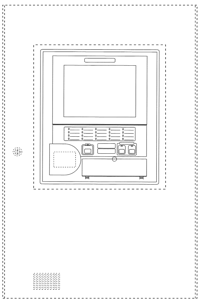

['fire alarm panel, front elevation view']

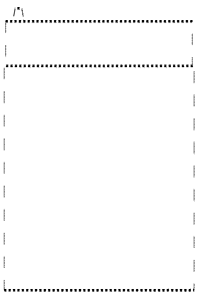

['fire alarm panel, bottom plan view']

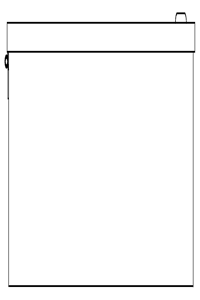

['base, bottom plan view']

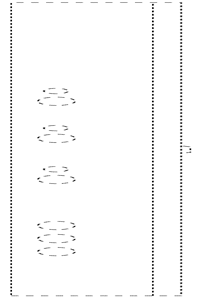

['fire alarm panel, left-side elevation view']

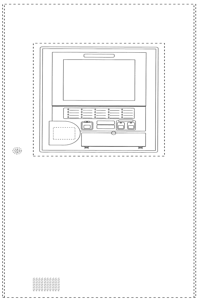

['fire alarm panel, front elevation view']

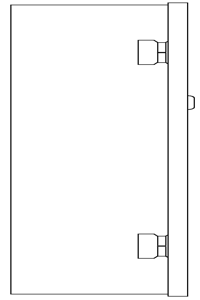

['fire alarm panel, left-side elevation view']

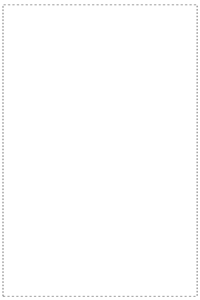

['fire alarm panel, rear elevation view']

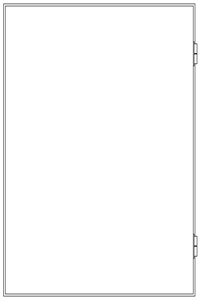

['fire alarm panel, rear elevation view']

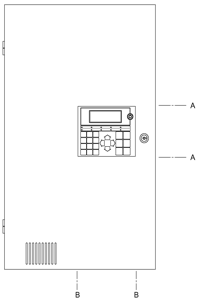

['fire alarm panel, front elevation view']

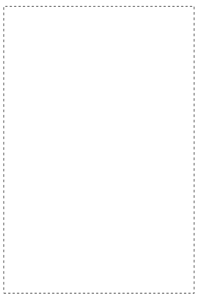

['fire alarm panel, rear elevation view']

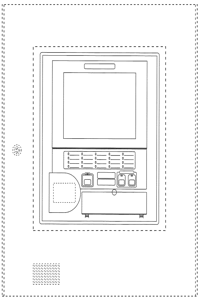

['fire alarm panel, front elevation view']

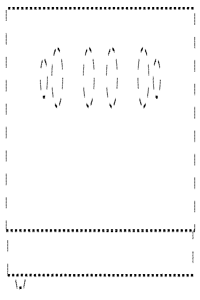

['fire alarm panel, top plan view']

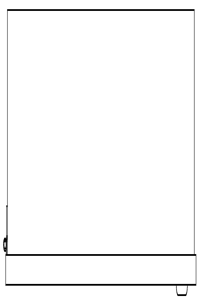

['fire alarm panel, top plan view']

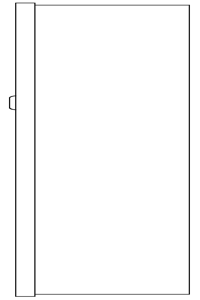

['fire alarm panel, right-side elevation view']

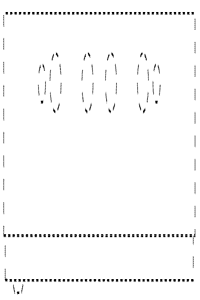

['fire alarm panel, top plan view']

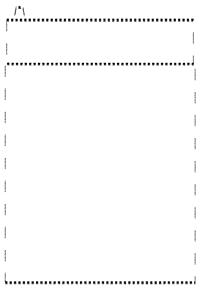

['fire alarm panel, bottom plan view']

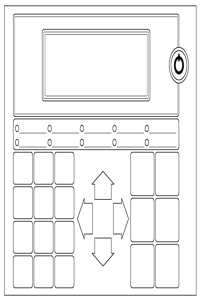

['base, enlarged view']

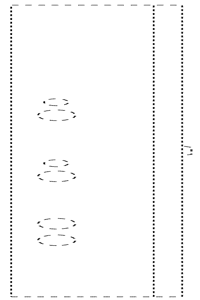

['fire alarm panel, left-side elevation view']

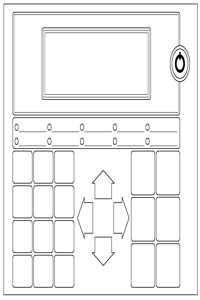

['base, enlarged view']

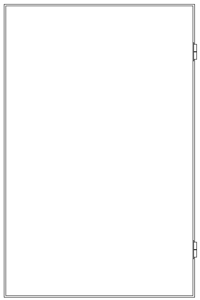

['fire alarm panel, rear elevation view']

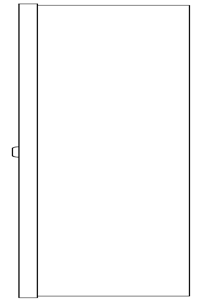

['fire alarm panel, right-side elevation view']

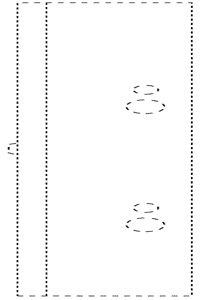

['fire alarm panel, right-side elevation view']

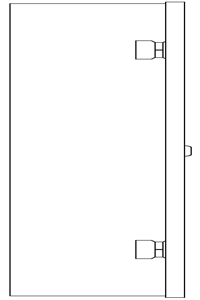

['fire alarm panel, left-side elevation view']

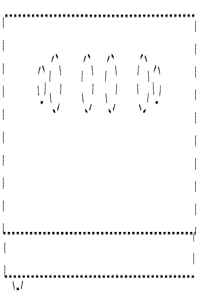

['fire alarm panel, top plan view']

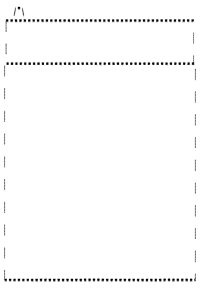

['fire alarm panel, bottom plan view']

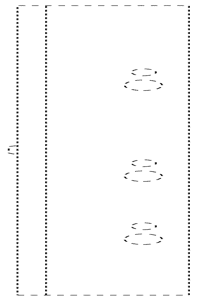

['fire alarm panel, right-side elevation view']

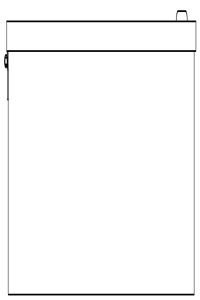

['base, bottom plan view']

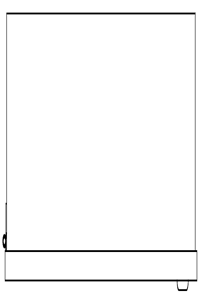

['fire alarm panel, top plan view']

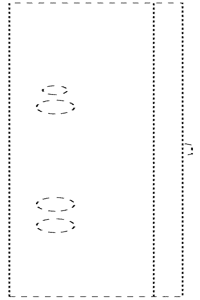

['fire alarm panel, left-side elevation view']

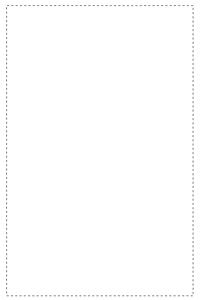

['fire alarm panel, rear elevation view']

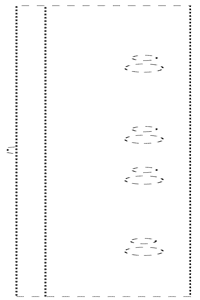

['fire alarm panel, right-side elevation view']

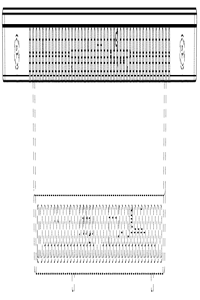

['wall-mount control panel, bottom view']

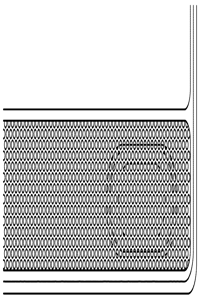

['wall-mount control panel, detail view']

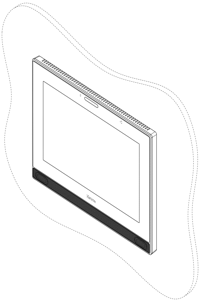

['wall-mount control panel, front perspective view']

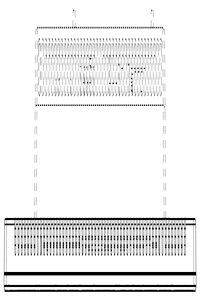

['wall-mount control panel, top view']

In [91]:
for pic in images:
    display(pic)

## Loading vector database for image

In [100]:
idx = read_index("image.index")

## Embed Query Image

In [107]:
queryImage = Image.open("/content/drive/My Drive/VectorSearchEngine/data/patent_figures/segmented_50000_v4/USD0734750-20150721-D00001_1.png", 'r') ## Replace with your path
query_embedding_img = get_single_image_embedding(queryImage)

## Search against the vector database

In [108]:
%%time
imgQuery = np.array(query_embedding_img) ## pass the array of either image or text of the user query
D, I = idx.search(imgQuery, k=35)
print(D)
print('\n')
print(I)

[[1.0550981e-10 2.2216606e+01 2.4145029e+01 2.6163389e+01 2.8235575e+01
  2.8895351e+01 2.9899511e+01 3.0001144e+01 3.0879345e+01 3.1740791e+01
  3.2055355e+01 3.2780468e+01 3.2936085e+01 3.2955055e+01 3.2968815e+01
  3.3007160e+01 3.3047356e+01 3.3130524e+01 3.3260735e+01 3.3440975e+01
  3.3477406e+01 3.3514149e+01 3.3588612e+01 3.3623875e+01 3.3683342e+01
  3.3701199e+01 3.3966106e+01 3.4063885e+01 3.4085648e+01 3.4214119e+01
  3.4240734e+01 3.4375881e+01 3.4439159e+01 3.4508450e+01 3.4672993e+01]]


[[41630 41622 41632 41631 41635 59959 49766 25066 55479 41621 40261 41634
  49758 63443 49745 49746 49761 49752 60031 49759 16070 49765 40262 63430
  37593 41629 40408 33917 63438 49753 20210 26157 49751 20206 41628]]
CPU times: user 14.9 ms, sys: 982 µs, total: 15.9 ms
Wall time: 29 ms


## Display the image

In [109]:
res = []
images = []
captions = []
for x in I:
    for pic in x:
        result = Image.open(data['figure_path'][pic], 'r')
        result = result.resize((200, 300))
        captions = caps[pic] + ", " + viewpoint[pic]
        images.extend((result, [captions]))

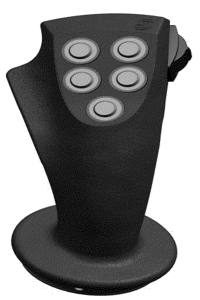

['joystick, top view']

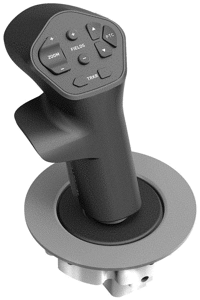

['joystick, top perspective view']

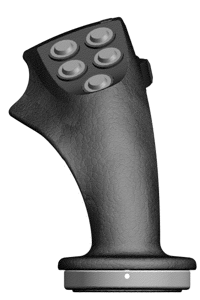

['joystick, front view']

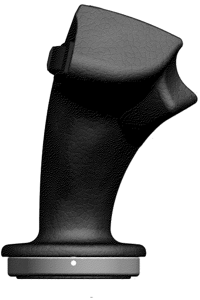

['joystick, rear view']

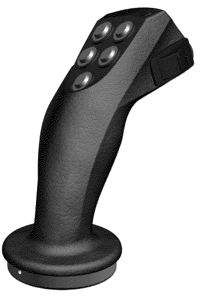

['joystick, front , top , right-hand side perspective view']

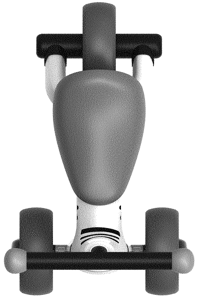

['push tricycle, top plan view']

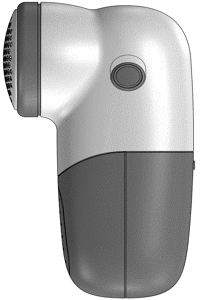

['fabric shaver, right side view']

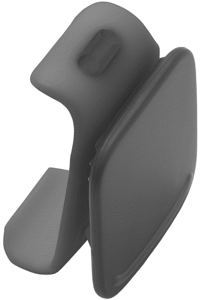

['holder for activity monitor, rear , bottom , and left side perspective view']

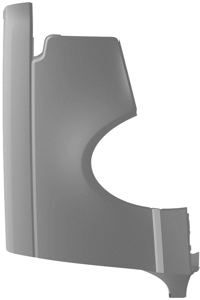

['rear quarter panel for a vehicle, front right perspective view']

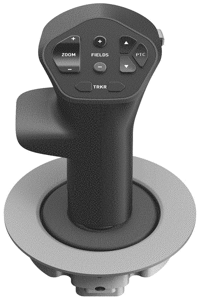

['joystick, top perspective view']

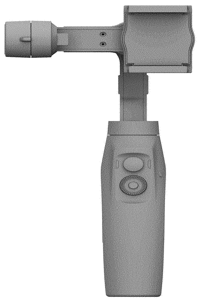

['three-axis gyro-stabilized head, front elevational view']

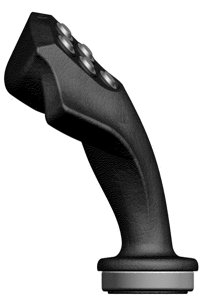

['joystick, left-hand side view']

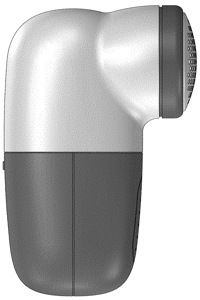

['fabric shaver, left side view']

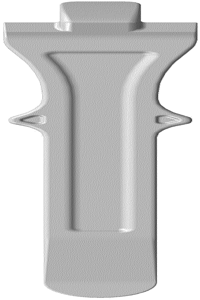

['upper tire iron, bottom plan view']

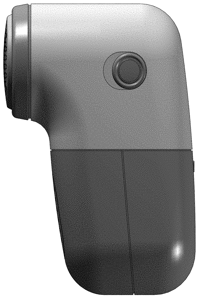

['fabric shaver, right side view']

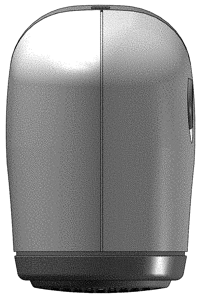

['fabric shaver, top view']

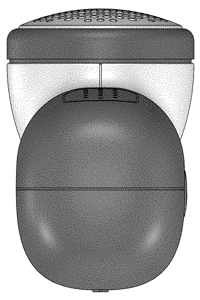

['fabric shaver, bottom view']

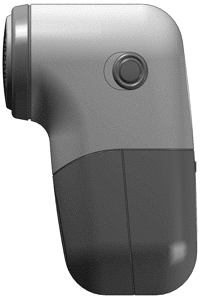

['fabric shaver, right side view']

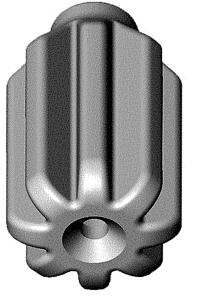

['rocket dog toy design, bottom perspective view']

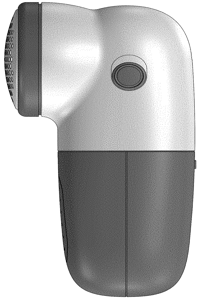

['fabric shaver, right side view']

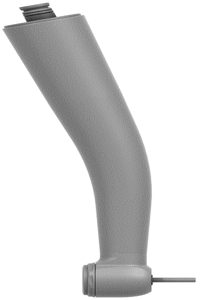

['dental handpiece, top view']

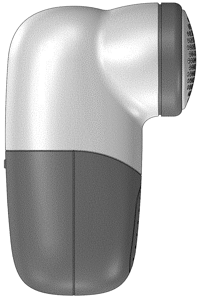

['fabric shaver, left side view']

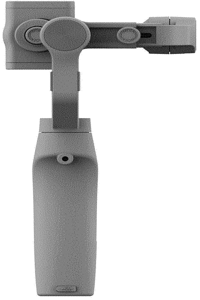

['three-axis gyro-stabilized head, rear elevational view']

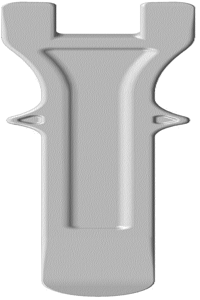

['lower tire iron, top plan view']

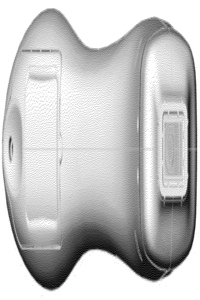

['light-based treatment device, bottom perspective view']

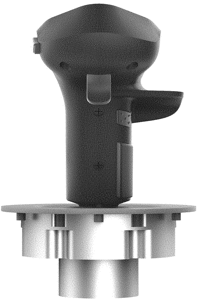

['joystick, rear view']

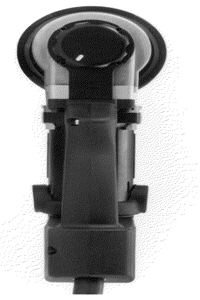

['bolt or nut tightening device, left side view']

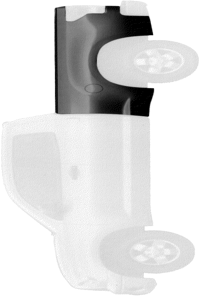

['gas cap, outer side view']

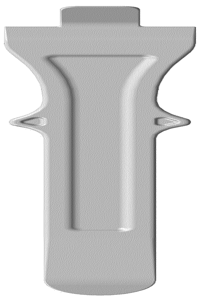

['upper tire iron, top plan view']

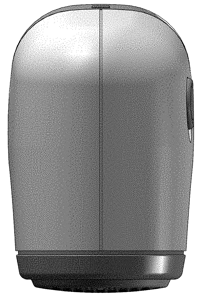

['fabric shaver, top view']

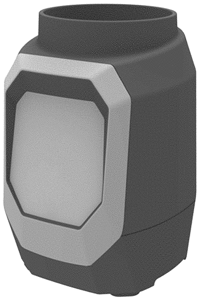

['cooker base, perspective view']

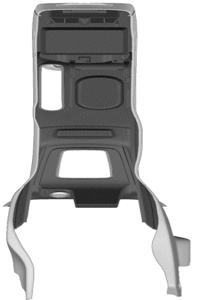

['center console, bottom plan view']

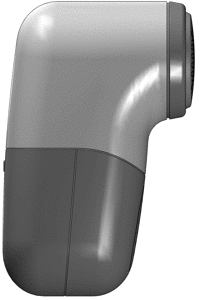

['fabric shaver, perspective view']

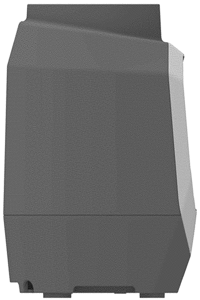

['cooker base, side view']

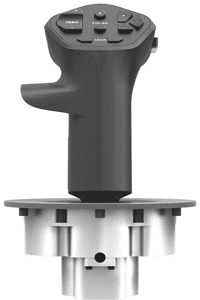

['joystick, front view']

In [110]:
for pic in images:
    display(pic)